In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords 
%matplotlib inline

In [2]:
amazon = pd.read_csv('amazon_5_percent.csv')
def sentiment(rating):
    if (rating == 1) or (rating == 2):
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Positive'
amazon['Sentiment'] = amazon['Rating'].apply(sentiment)
def all_word(word):
    letters_only = re.sub("[^a-zA-Z]", " ", word)
    words = letters_only.lower().split()
    return (" ".join(words))

amazon['Title_no_punc'] = amazon['Title'].apply(all_word)
amazon['Review_no_punc'] = amazon['Review'].apply(all_word)

stops = list(stopwords.words('english'))
stops.extend(['book', 'product', 'movie', 'music', 'album', 'cd'])
stops = set(stops)


def meaningful_word_specific(word):
    letters_only = re.sub("[^a-zA-Z]", " ", word)
    words = letters_only.lower().split()   
    meaningful_words = [w for w in words if not w in stops] 
    return( " ".join( meaningful_words ))

amazon['Title_meaningful'] = amazon['Title_no_punc'].apply(meaningful_word_specific)
amazon['Review_meaningful'] = amazon['Review_no_punc'].apply(meaningful_word_specific)

amazon['Combination'] = amazon[['Title_meaningful', 'Review_meaningful']].apply(lambda x:(x['Title_meaningful'] +' '+ x['Review_meaningful']) , axis = 1)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.model_selection import cross_val_score, learning_curve, KFold, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

## Validate the model stabilty by KFold (n_split = 5)

In [4]:
kf = KFold(n_splits = 5, shuffle= True)

In [5]:
title = amazon['Title']
review = amazon['Review']
sentiment = amazon['Sentiment']
combination = amazon['Combination']

In [6]:
model_1vR = LogisticRegression(multi_class='ovr', class_weight='balanced')

In [7]:
from sklearn.utils import shuffle
title,review, combination, sentiment = shuffle(title, review, combination, sentiment)

In [8]:
def calc_train_error(X_train, y_train, model):
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    f1 = f1_score(y_train, predictions, average ='macro')
    report = classification_report(y_train, predictions)
    accuracy = accuracy_score(y_train, predictions)
    confMatrix = confusion_matrix(y_train, predictions)
    logloss = log_loss(y_train,predictProba)
    return{
        'report' : report, 
        'f1' : f1,
        'accuracy': accuracy,
        'confusion': confMatrix,
        'logloss' : logloss
    }
def calc_validation_error(X_test, y_test, model):
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    f1 = f1_score(y_test, predictions, average ='macro')
    report = classification_report(y_test, predictions)
    accuracy = accuracy_score(y_test, predictions)
    confMatrix = confusion_matrix(y_test, predictions)
    logloss = log_loss(y_test,predictProba)
    return{
        'report' : report, 
        'f1' : f1,
        'accuracy': accuracy,
        'confusion': confMatrix,
        'logloss' : logloss
    }
def calc_metrics(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [9]:
def pipeline_tfidf_1vr(X_train, X_test, y_train, y_test):
    pipeline = Pipeline([('bow', CountVectorizer(analyzer='word', max_features =30000, ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer()),
                         ('classifier', model_1vR)])
    train_error, test_error = calc_metrics(X_train, y_train, X_test, y_test, pipeline)
    error = {'train_error' : train_error, 'test_error': test_error}
    return error


In [10]:
error_tfidf_1vr_title = []
for train_index, val_index in kf.split(title, sentiment):
    
    X_train, X_test = title.iloc[train_index], title.iloc[val_index]
    y_train, y_test = sentiment.iloc[train_index], sentiment.iloc[val_index]
    
    error_tfidf_1vr_title.append(pipeline_tfidf_1vr(X_train, X_test, y_train, y_test))

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [11]:
error_tfidf_1vr_review = []
for train_index, val_index in kf.split(review, sentiment):
    
    X_train, X_test = review.iloc[train_index], review.iloc[val_index]
    y_train, y_test = sentiment.iloc[train_index], sentiment.iloc[val_index]
    
    error_tfidf_1vr_review.append(pipeline_tfidf_1vr(X_train, X_test, y_train, y_test))

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [12]:
error_tfidf_1vr_combination = []
for train_index, val_index in kf.split(combination, sentiment):
    
    X_train, X_test = combination.iloc[train_index], combination.iloc[val_index]
    y_train, y_test = sentiment.iloc[train_index], sentiment.iloc[val_index]
    
    error_tfidf_1vr_combination.append(pipeline_tfidf_1vr(X_train, X_test, y_train, y_test))

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warnin

In [32]:
def create_df_kfold(error):
    matrix = []
    for i in error:
        matrix.append([i['train_error']['accuracy'], i['train_error']['f1'], i['train_error']['logloss'],
                  i['test_error']['accuracy'], i['test_error']['f1'], i['test_error']['logloss']
                  ])

    calc_error = pd.DataFrame(matrix, columns = ['Train Accuracy', 'Train F1 Score', 'Train Log Loss', 
                                             
                                             'Test Accuracy', 'Test F1 Score', 'Test Log Loss',
                                             ])
    average = []
    for i in calc_error:
        average.append(calc_error[i].mean())
    matrix.append(average)
    
    calc_error = pd.DataFrame(matrix, columns = ['Train Accuracy', 'Train F1 Score', 'Train Log Loss', 
                                             
                                             'Test Accuracy', 'Test F1 Score', 'Test Log Loss',
                                             ])

    calc_error.index = ['Iteration 1', 'Iteration 2', 'Iteration 3', 'Iteration 4', 'Iteration 5', 'Average']
    return calc_error
create_df_kfold(error_tfidf_1vr_title)

,Train Accuracy,Train F1 Score,Train Log Loss,Test Accuracy,Test F1 Score,Test Log Loss
Iteration 1,0.748921,0.710657,0.655053,0.675726,0.623452,0.749617
Iteration 2,0.746579,0.708142,0.656347,0.679616,0.629484,0.746037
Iteration 3,0.749318,0.711297,0.654991,0.672740,0.621098,0.748551
Iteration 4,0.749135,0.710873,0.655698,0.677197,0.626178,0.745640
Iteration 5,0.748615,0.710170,0.655471,0.675553,0.626230,0.746204
Average,0.748514,0.710228,0.655512,0.676166,0.625288,0.747210


In [29]:
for i, j in zip(error_tfidf_1vr_title, range(1, len(error_tfidf_1vr_title)+1)):
    print('Iteration Title {}'.format(j))
    print(i['test_error']['report'])

Iteration Title 1
              precision    recall  f1-score   support

    Negative       0.73      0.71      0.72     14568
     Neutral       0.43      0.36      0.39      7207
    Positive       0.72      0.79      0.75     14725

   micro avg       0.68      0.68      0.68     36500
   macro avg       0.63      0.62      0.62     36500
weighted avg       0.67      0.68      0.67     36500

Iteration Title 2
              precision    recall  f1-score   support

    Negative       0.74      0.72      0.73     14579
     Neutral       0.44      0.37      0.41      7311
    Positive       0.72      0.79      0.75     14610

   micro avg       0.68      0.68      0.68     36500
   macro avg       0.63      0.63      0.63     36500
weighted avg       0.67      0.68      0.67     36500

Iteration Title 3
              precision    recall  f1-score   support

    Negative       0.73      0.72      0.72     14568
     Neutral       0.43      0.36      0.39      7338
    Positive       0.

In [33]:
create_df_kfold(error_tfidf_1vr_review)

,Train Accuracy,Train F1 Score,Train Log Loss,Test Accuracy,Test F1 Score,Test Log Loss
Iteration 1,0.789819,0.752737,0.576740,0.728904,0.678043,0.663187
Iteration 2,0.790703,0.754050,0.575722,0.728685,0.678092,0.664006
Iteration 3,0.789942,0.753556,0.576281,0.723973,0.672015,0.663668
Iteration 4,0.790978,0.754001,0.574538,0.724184,0.673995,0.670130
Iteration 5,0.790629,0.753761,0.573942,0.722924,0.672526,0.673029
Average,0.790414,0.753621,0.575445,0.725734,0.674934,0.666804


In [30]:
for i, j in zip(error_tfidf_1vr_review, range(1, len(error_tfidf_1vr_review)+1)):
    print('Iteration Review {}'.format(j))
    print(i['test_error']['report'])

Iteration Review 1
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79     14715
     Neutral       0.48      0.42      0.44      7294
    Positive       0.79      0.82      0.80     14491

   micro avg       0.73      0.73      0.73     36500
   macro avg       0.68      0.68      0.68     36500
weighted avg       0.72      0.73      0.72     36500

Iteration Review 2
              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78     14530
     Neutral       0.48      0.42      0.45      7300
    Positive       0.79      0.82      0.81     14670

   micro avg       0.73      0.73      0.73     36500
   macro avg       0.68      0.68      0.68     36500
weighted avg       0.72      0.73      0.72     36500

Iteration Review 3
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78     14597
     Neutral       0.46      0.41      0.43      7241
    Positive      

In [15]:
create_df_kfold(error_tfidf_1vr_combination)

,Train Accuracy,Train F1 Score,Train Log Loss,Test Accuracy,Test F1 Score,Test Log Loss
Iteration 1,0.787901,0.749653,0.579488,0.722493,0.671059,0.671306
Iteration 2,0.787305,0.749641,0.578965,0.723945,0.672054,0.674612
Iteration 3,0.787593,0.749371,0.579562,0.723068,0.671882,0.671551
Iteration 4,0.788471,0.751028,0.578704,0.721417,0.667104,0.673359
Iteration 5,0.787314,0.749792,0.580499,0.725910,0.672077,0.666505
Average,0.787717,0.749897,0.579444,0.723367,0.670835,0.671467


In [31]:
for i, j in zip(error_tfidf_1vr_combination, range(1, len(error_tfidf_1vr_combination)+1)):
    print('Iteration Combination {}'.format(j))
    print(i['test_error']['report'])

Iteration Combination 1
              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78     14516
     Neutral       0.47      0.40      0.44      7414
    Positive       0.78      0.82      0.80     14570

   micro avg       0.72      0.72      0.72     36500
   macro avg       0.67      0.67      0.67     36500
weighted avg       0.71      0.72      0.72     36500

Iteration Combination 2
              precision    recall  f1-score   support

    Negative       0.78      0.79      0.78     14594
     Neutral       0.46      0.41      0.44      7241
    Positive       0.78      0.81      0.80     14665

   micro avg       0.72      0.72      0.72     36500
   macro avg       0.67      0.67      0.67     36500
weighted avg       0.72      0.72      0.72     36500

Iteration Combination 3
              precision    recall  f1-score   support

    Negative       0.77      0.79      0.78     14566
     Neutral       0.48      0.41      0.44      7388
   

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


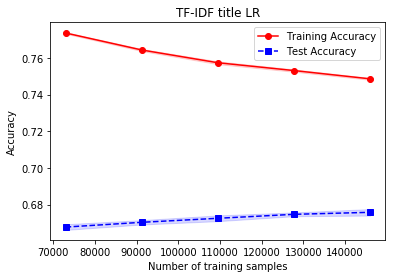

In [17]:
def learning_curve_1vr(series, name =''):
    train_sizes, train_scores, test_scores = learning_curve(estimator=Pipeline([('bow', CountVectorizer(analyzer='word', 
                                                                                                    max_features =30000,
                                                                                                    ngram_range=(1,2))),
                                                                             ('tfidf', TfidfTransformer()),
                                                                             ('classifier', model_1vR)]),
                                                       X=series,
                                                       y=sentiment,
                                                       train_sizes=np.linspace(0.5, 1.0, 5),
                                                       cv=5)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plot = plt.plot(train_sizes, train_mean, color='red', marker='o', label='Training Accuracy')
    
    plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15, color='red')


    plt.plot(train_sizes, test_mean, color='blue', linestyle='--', marker='s', 
        label='Test Accuracy')
    plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='blue')

    plt.title('TF-IDF {} LR'.format(name))
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    return plot
learning_curve_1vr(title, name ='title')

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


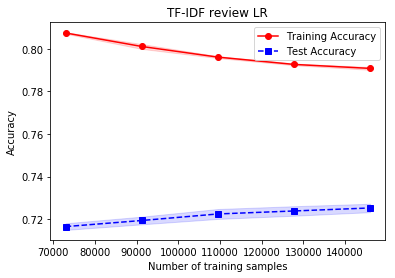

In [18]:
learning_curve_1vr(review, 'review')

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


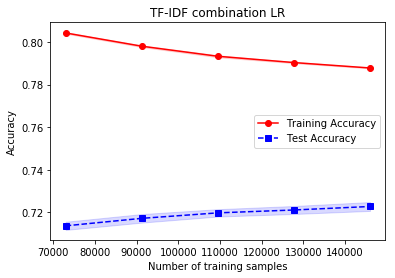

In [19]:
learning_curve_1vr(combination, 'combination')

In [20]:
X_train, X_test, y_train, y_test = train_test_split(amazon['Combination'], amazon['Rating'], test_size = 0.2)
cv = CountVectorizer(analyzer='word', max_features =30000, ngram_range=(1,2))
X_train = cv.fit_transform(X_train)

tfidf = TfidfTransformer()
X_train = tfidf.fit_transform(X_train)


## Trying Grid Search

In [21]:
param_solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
param_iter = [100, 200, 300, 400, 500]
param_grid = {'solver':param_solver, 'max_iter':param_iter}

gs = GridSearchCV(model_1vR,param_grid,scoring='accuracy')

In [22]:
gs = gs.fit(X_train, y_train)

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. 

In [23]:
gs.best_params_

{'max_iter': 100, 'solver': 'liblinear'}

In [24]:
gs.best_score_

0.5157399416430362

In [61]:
pipeline_title = Pipeline([('bow', CountVectorizer(analyzer=meaningful_word_specific, max_features =30000, ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer()),
                         ('classifier', model_1vR)])
pipeline_review = Pipeline([('bow', CountVectorizer(analyzer=meaningful_word_specific, max_features =30000, ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer()),
                         ('classifier', model_1vR)])
pipeline_combination = Pipeline([('bow', CountVectorizer(analyzer=meaningful_word_specific, max_features =30000, ngram_range=(1,2))),
                         ('tfidf', TfidfTransformer()),
                         ('classifier', model_1vR)])

pipeline_title.fit(amazon['Title_meaningful'], amazon['Sentiment'])
pipeline_review.fit(amazon['Review_meaningful'], amazon['Sentiment'])
pipeline_combination.fit(amazon['Review_meaningful'], amazon['Sentiment'])

C:\Users\MSI\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer=<function meaningful_word_specific at 0x000002C5516EDD08>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=30000, min_df=1, ngram_range=(1, 2)...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [62]:
import pickle
pickle.dump(pipeline_title, open('model_predict_amazon_title.sav', 'wb'))
pickle.dump(pipeline_review, open('model_predict_amazon_review.sav', 'wb'))
pickle.dump(pipeline_combination, open('model_predict_amazon_combination.sav', 'wb'))

In [69]:
pipeline_title.predict_proba(['Nothing'])

array([[0.11366939, 0.2443922 , 0.64193841]])

In [70]:
amazon['Sentiment'].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)